# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [2]:
import gym
#gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

### 2. Define the Architecture of the Policy

In [19]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

[2019-04-10 18:55:37,742] Making new env: CartPole-v0


observation space: Box(4,)
action space: Discrete(2)


In [20]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self,s_size=8,h_size=16,a_size=4):
        super(Policy,self).__init__()
        self.fc1 = nn.Linear(s_size,h_size)
        self.fc2 = nn.Linear(h_size,a_size)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim=1)
    def act(self,state):
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(),m.log_prob(action)



[2019-04-10 18:56:09,024] Making new env: LunarLander-v2


observation space: Box(8,)
action space: Discrete(4)


### 3. Train the Agent with REINFORCE

In [21]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)


def reinforce(n_episodes=10000,max_t=1000,gamma=1.0,print_every=100):
    
    """
    max_t max time
    """
    
    scores = []
    scores_deque = deque()
    for i_episode in range(1,n_episodes+1):
        """
        根据策略生成一条轨迹
        
        """
        log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action,log_prob = policy.act(state)
            log_probs.append(log_prob)
            state,reward,done,_ = env.step(action)
            rewards.append(reward)
            if done:
                break
        scores.append(sum(rewards))
        scores_deque.append(sum(rewards))
    
        """
        len(rewards) = len(t_max)
        R = 公式中的G(gamma*reward)
        """
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts,rewards)])
        
        policy_loss = []
        for log_prob in log_probs:
            """
            邱老师书中14.56
            """
            policy_loss.append(-log_prob*R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce()

Episode 100	Average Score: -272.41
Episode 200	Average Score: -239.33
Episode 300	Average Score: -231.91
Episode 400	Average Score: -232.55
Episode 500	Average Score: -292.94
Episode 600	Average Score: -339.79
Episode 700	Average Score: -372.59
Episode 800	Average Score: -395.38
Episode 900	Average Score: -411.29
Episode 1000	Average Score: -417.25


KeyboardInterrupt: 

### 4. Plot the Scores

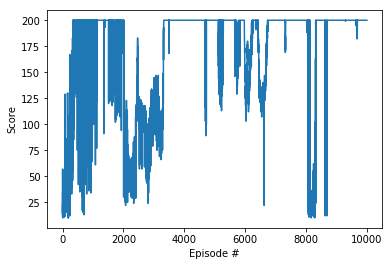

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [16]:
env = gym.make('CartPole-v0')

state = env.reset()
for t in range(1000):
    action, _ = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()

[2019-04-10 18:47:05,286] Making new env: CartPole-v0
